# Sec Recon Network Visualization
This notebook is for the visualization of the Secretory Pathway Reconstruction. Here we try different approaches  the visualization. First, we generate a python dictionary with all the necessary information that will be used for downstream analysys. The first analysis is bases on a dimensionality reduction of the data set for UMAP plotting of the genes. In the second analysis we generate a network of the Sec Recon in which all the nodes represent genes interconnected by the processes they share.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

from itertools import combinations
from utils import get_gene_color, flatten_processes, adjust_color_alpha, categorize_location

## 1 Generate a "gene_dict" dictionary with all the necessary information stored into it

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_csv("Input/masterTable.csv")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")
complexes = pd.read_csv("Input/Complexes.csv")
cho2human_mapping = pd.read_csv("cho2human_mapping.tsv", sep='\t')
subcell = pd.read_csv("Input/subcellular_localization.csv")

In [3]:
subcell

Gene_name_canonical consensus graph-based annotation (this study)  \
0                   ADSL                                       cytosol   
1                 AKAP13                               14-3-3_scaffold   
2                  AP5Z1                               14-3-3_scaffold   
3                   ARAF                               14-3-3_scaffold   
4               ARHGAP32                               14-3-3_scaffold   
...                  ...                                           ...   
8536             PPP2R1B                                       cytosol   
8537                XPO7                                       cytosol   
8538             DNAJC17                                  unclassified   
8539               ESRRA                                       nucleus   
8540      STRN3 (A0AV58)                                  unclassified   

      Leiden cluster label (this study) Ground truth (ML6.0)  \
0                                     0                  NaN   
1                                     0                  NaN   
2                                     0                  NaN   
3                                     0                  NaN   
4                                     0                  NaN   
...                                 ...                  ...   
8536                                201                  NaN   
8537                                201                  NaN   
8538                                202                  NaN   
8539                                202                  NaN   
8540                                202                  NaN   

     Itzhak et al. 2016, compartment Itzhak et al. 2016, global  
0              Large Protein Complex           Mostly Cytosolic  
1              Large Protein Complex   Organellar and Cytosolic  
2                           Endosome           Mostly Cytosolic  
3                                NaN           Mostly Cytosolic  
4                                NaN   Organellar and Cytosolic  
...                              ...                        ...  
8536           Large Protein Complex           Mostly Cytosolic  
8537           Large Protein Complex           Mostly Cytosolic  
8538           Large Protein Complex      Nuclear and Cytosolic  
8539                             NaN             Mostly Nuclear  
8540           Large Protein Complex         Broad distribution  

[8541 rows x 6 columns]

In [4]:
subcell
subcell_dict = dict(zip(subcell['Gene_name_canonical'], subcell['consensus graph-based annotation (this study)']))
#subcell_dict_2 = {}
#for key, value in subcell_dict.items():
    # Remove parentheses and the keys contents
#    new_key = key.split(" (")[0]
#    subcell_dict_2[new_key] = value
    
subcell_dict

{'ADSL': 'cytosol',
 'AKAP13': '14-3-3_scaffold',
 'AP5Z1': '14-3-3_scaffold',
 'ARAF': '14-3-3_scaffold',
 'ARHGAP32': '14-3-3_scaffold',
 'ARHGEF2': '14-3-3_scaffold',
 'BAD': '14-3-3_scaffold',
 'BRAF (P15056)': 'cytosol',
 'CAMSAP2': '14-3-3_scaffold',
 'CAMSAP3': '14-3-3_scaffold',
 'CCDC88A': 'ER',
 'CDC25B': '14-3-3_scaffold',
 'CDR2L': '14-3-3_scaffold',
 'CENPJ': '14-3-3_scaffold',
 'CEP112': '14-3-3_scaffold',
 'CEP170 (B2RTS4)': '14-3-3_scaffold',
 'CEP170 (E7EWM2)': '14-3-3_scaffold',
 'CEP170B': '14-3-3_scaffold',
 'CFAP410': '14-3-3_scaffold',
 'CLASP1': '14-3-3_scaffold',
 'CLASP2 (E3W994)': '14-3-3_scaffold',
 'CLASP2 (E7ERI8)': '14-3-3_scaffold',
 'CRLF3': '14-3-3_scaffold',
 'CRTC1': '14-3-3_scaffold',
 'CRTC2': '14-3-3_scaffold',
 'CRTC3': '14-3-3_scaffold',
 'DEF6': '14-3-3_scaffold',
 'E2F8': '14-3-3_scaffold',
 'EML3': '14-3-3_scaffold',
 'EXO1': '14-3-3_scaffold',
 'FAM117A': '14-3-3_scaffold',
 'FAM13A': '14-3-3_scaffold',
 'FBXO45': '14-3-3_scaffold',
 'FOXK1':

In [5]:
unique_values = {value for value in subcell_dict.values()}
unique_values_list = list(unique_values)
unique_values_list

['nucleus',
 'ER',
 '14-3-3_scaffold',
 'stress_granule',
 'proteasome',
 'peroxisome',
 'centrosome',
 'early_endosome',
 'plasma_membrane',
 'nucleolus',
 'translation',
 'trans-Golgi',
 'unclassified',
 'mitochondrion',
 'Golgi',
 'p-body',
 'cytosol',
 'lysosome',
 'actin_cytoskeleton',
 'ERGIC',
 'recycling_endosome']

In [6]:
# Standarization of the subcellular compartments

for key in subcell_dict:
    if subcell_dict[key] == 'early_endosome':
        subcell_dict[key] = list(['Early Endosome'])
    elif subcell_dict[key] == 'centrosome':
        subcell_dict[key] = list(['Centrosome'])
    elif subcell_dict[key] == 'ER':
        subcell_dict[key] = list(['Endoplasmic Reticulum'])
    elif subcell_dict[key] == 'mitochondrion':
        subcell_dict[key] = list(['Mitochondria'])
    elif subcell_dict[key] == 'stress_granule':
        subcell_dict[key] = list(['Stress Granule'])
    elif subcell_dict[key] == 'unclassified':
        subcell_dict[key] = None
    elif subcell_dict[key] == 'peroxisome':
        subcell_dict[key] = list(['Peroxisome'])
    elif subcell_dict[key] == '14-3-3_scaffold':
        subcell_dict[key] = None
    elif subcell_dict[key] == 'recycling_endosome':
        subcell_dict[key] = list(['Recycling Endosome'])
    elif subcell_dict[key] == 'plasma_membrane':
        subcell_dict[key] = list(['Plasma Membrane'])
    elif subcell_dict[key] == 'lysosome':
        subcell_dict[key] = list(['Lysosome'])
    elif subcell_dict[key] == 'translation':
        subcell_dict[key] = list(['Translation'])
    elif subcell_dict[key] == 'actin_cytoskeleton':
        subcell_dict[key] = list(['Actin Cytoskeleton'])
    elif subcell_dict[key] == 'cytosol':
        subcell_dict[key] = list(['Cytoplasm'])
    elif subcell_dict[key] == 'nucleus':
        subcell_dict[key] = list(['Nucleus'])
    elif subcell_dict[key] == 'ERGIC':
        subcell_dict[key] = list(['ERGIC'])
    elif subcell_dict[key] == 'p-body':
        subcell_dict[key] = list(['P-Body'])
    elif subcell_dict[key] == 'trans-Golgi':
        subcell_dict[key] = list(['trans-Golgi'])
    elif subcell_dict[key] == 'nucleolus':
        subcell_dict[key] = list(['Nucleolus'])
    elif subcell_dict[key] == 'proteasome':
        subcell_dict[key] = list(['Proteasome'])
    elif subcell_dict[key] == 'Golgi':
        subcell_dict[key] = list(['Golgi'])

In [7]:
# Create a dictionary for quick lookup from cho2human_mapping
cho_id_lookup = dict(zip(cho2human_mapping['HUMAN_ID'], cho2human_mapping['CHO_ID']))

In [8]:
# Create a dictionary for quick lookup from cho2human_mapping
for index, row in secrecon.iterrows():
    if pd.isna(row['CHO_ENTREZID']) or row['CHO_ENTREZID'] == '':
        human_id = row['ENTREZID']
        cho_id = cho_id_lookup.get(human_id)
        if cho_id is not None:
            secrecon.at[index, 'CHO_ENTREZID'] = cho_id

In [9]:
# Trim the information if the Subcellular localization column in order to keep just the compartment name
secrecon['Subcellular location [CC]'] = secrecon['Subcellular location [CC]'].apply(categorize_location)
secrecon['Subcellular_location_2'] = secrecon['SYMBOL'].map(subcell_dict)

In [10]:
#Generate dictionaries

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['SYMBOL']
    # Grab the processes and filter out any NaN values
    # Add the subcellular localizations
    processes = row[['Process.1', 'Process.2', 'Process.3', 'Process.4', 'Process.5',
                     'Process.6', 'Process.7', 'Process.8', 'Process.9', 'Process.10']].dropna().tolist()
    if pd.isna(row['Subcellular_location_2']):
        localization = row['Subcellular location [CC]']
    else:
        localization = row['Subcellular_location_2']
    
    gene_dict[gene] = {'processes': processes, 'subcellular_localization': localization}
    
# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})
    

#Complexes dict

# Pre-select all the complexes in Human
complexes = complexes[complexes['Organism'] == 'Human']
gene_complex_dict = {}

for index, row in complexes.iterrows():
    gene_symbol = row['SYMBOL']
    complex_name = row['ComplexName']
    # Check if the gene symbol is already a key in the dictionary
    if gene_symbol in gene_complex_dict:
        # Append the complex name to the existing list
        gene_complex_dict[gene_symbol].append(complex_name)
    else:
        # Create a new key with the complex name as the first item in the list
        gene_complex_dict[gene_symbol] = [complex_name]

In [11]:
# Add the complexes to the gene_dict. If a gene is not part of any complex, we will put 'Not part of any complex'
for gene in gene_dict:
    gene_dict[gene]['complex'] = gene_complex_dict.get(gene)#, 'Not part of any complex')

In [12]:
unique_values = []
for v in gene_dict.values():
    locations = v['subcellular_localization']
    for location in locations:
        unique_values.append(location)

In [13]:
set(unique_values)

{'Actin Cytoskeleton',
 'Centrosome',
 'Cytoplasm',
 'ERGIC',
 'Early Endosome',
 'Endoplasmic Reticulum',
 'Endosome',
 'Golgi',
 'Lysosome',
 'Mitochondria',
 'Nucleolus',
 'Nucleus',
 'Phagosome',
 'Plasma Membrane',
 'Proteasome',
 'Recycling Endosome',
 'Stress Granule',
 'Translation',
 'cis-Golgi',
 'trans-Golgi'}

In [14]:
count = 0
for key in gene_dict:
    if gene_dict[key]['subcellular_localization'] == []:
        print(key,gene_dict[key]['subcellular_localization'])
        count += 1
        
print(count)

ACAP3 []
ALG1L []
ALG1L2 []
ARAF []
ARPC1B []
B3GNTL1 []
BAG2 []
CUL1 []
DDI1 []
DNAJC6 []
FBXO8 []
GCNT4 []
GLT1D1 []
GPLD1 []
HSP90AA5P []
HSP90AB3P []
HSP90AB4P []
HSPA12B []
HSPA1L []
MICALCL []
PIK3CA []
PSMD4 []
PSMD5 []
RAB44 []
SEC1P []
SEC22C []
TBC1D10C []
TBC1D22B []
TBC1D9 []
TMED6 []
TRAPPC3L []
UBA7 []
UBE2D2 []
UBE2D4 []
UBQLN3 []
UBQLNL []
UBXN2A []
WDR38 []
38


## 2 Dimensionality reduction / one hot encoding for UMAP visualization

In [34]:
from sklearn.neighbors import NearestNeighbors
import umap
import igraph as ig
import leidenalg as la
import seaborn as sns

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/

In [35]:
# One hot encoding

# Flatten the dictionary
flattened_data = []
for gene, attributes in gene_dict.items():
    for key, values in attributes.items():
        if key == 'subcellular_localization':  # Skip this subkey
            continue
        if values is None:
            continue
        if not isinstance(values, list):
            values = [values]
        for value in values:
            flattened_data.append({'gene': gene, 'attribute_type': key, 'attribute_value': value})

# Create a DataFrame
df = pd.DataFrame(flattened_data)
one_hot_encoded_df = pd.get_dummies(df, columns=['attribute_value'], prefix='', prefix_sep='').groupby(['gene']).sum().reset_index()

one_hot_encoded_df

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_14275/2736490671.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  one_hot_encoded_df = pd.get_dummies(df, columns=['attribute_value'], prefix='', prefix_sep='').groupby(['gene']).sum().reset_index()


gene  17S U2 snRNP  26S proteasome  3M complex  \
0    A3GALT2             0               0           0   
1     A4GALT             0               0           0   
2      A4GNT             0               0           0   
3       ABL1             0               0           0   
4       ABL2             0               0           0   
..       ...           ...             ...         ...   
883   XXYLT1             0               0           0   
884    XYLT1             0               0           0   
885    XYLT2             0               0           0   
886     YKT6             0               0           0   
887     YOD1             0               0           0   

     ABL2-HRAS-RIN1 complex  ACAP1-CLTC-SLC2A4 complex  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         1                          0   
..                      ...                        ...   
883                       0                          0   
884                       0                          0   
885                       0                          0   
886                       0                          0   
887                       0                          0   

     ACK1 signaling complex  ACK1-GBR2-AXL complex  ACK1-GRB2-ALK complex  \
0                         0                      0                      0   
1                         0                      0                      0   
2                         0                      0                      0   
3                         0                      0                      0   
4                         0                      0                      0   
..                      ...                    ...                    ...   
883                       0                      0                      0   
884                       0                      0                      0   
885                       0                      0                      0   
886                       0                      0                      0   
887                       0                      0                      0   

     ACK1-GRB2-EGFR complex  ...  p300-MDM2-p53 protein complex  \
0                         0  ...                              0   
1                         0  ...                              0   
2                         0  ...                              0   
3                         0  ...                              0   
4                         0  ...                              0   
..                      ...  ...                            ...   
883                       0  ...                              0   
884                       0  ...                              0   
885                       0  ...                              0   
886                       0  ...                              0   
887                       0  ...                              0   

     p38gamma-Hsp90-K-Ras complex  p53 homotetramer complex  p53-BCL2 complex  \
0                               0                         0                 0   
1                               0                         0                 0   
2                               0                         0                 0   
3                               0                         0                 0   
4                               0                         0                 0   
..                            ...                       ...               ...   
883                             0                         0                 0   
884                             0                         0                 0   
885                             0                         0                 0   
886                             0                         0               

In [36]:
# Prepare the data (excluding the gene column for the KNN input)
X = one_hot_encoded_df.drop('gene', axis=1)

# Consistent distance metric
distance_metric = 'euclidean'  # Choose 'euclidean', 'cosine', etc.

In [37]:
# Initialize the KNN model with consistent n_neighbors
n_neighbors = 90  # Adjust as needed
knn = NearestNeighbors(n_neighbors=n_neighbors, metric=distance_metric)
knn.fit(X)
distances, indices = knn.kneighbors(X)

In [38]:
# Apply UMAP with consistent parameters
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=0.1,  # Adjust as needed
    n_components=2,
    spread=40,  # Adjust as needed
    random_state=42,
    metric=distance_metric
)
embedding = reducer.fit_transform(X)

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


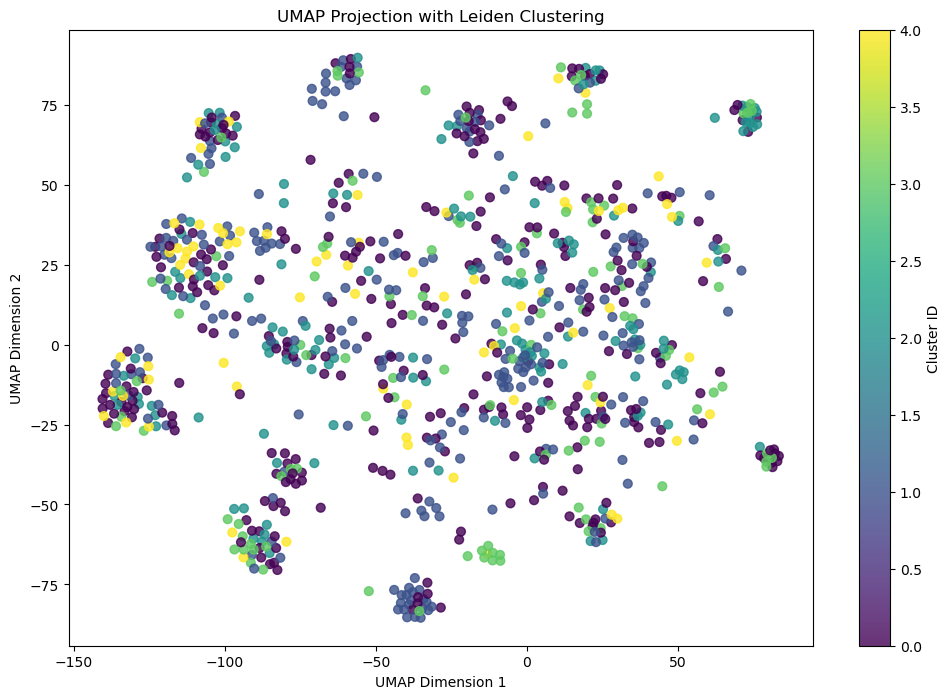

In [39]:
# Create a Graph for Leiden Algorithm
G = nx.Graph()
for idx, neighbors in enumerate(indices):
    for neighbor in neighbors:
        G.add_edge(idx, neighbor)

# Convert to iGraph
ig_graph = ig.Graph.from_networkx(G)

# Apply Leiden Algorithm with adjustable resolution
partition = la.find_partition(ig_graph, la.ModularityVertexPartition)

# Visualize UMAP with Leiden Clusters
plt.figure(figsize=(12, 8))
cluster_membership = np.array(partition.membership)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=cluster_membership,
    cmap='viridis',
    s=40,  # Adjust point size
    alpha=0.8  # Adjust transparency
)

plt.title('UMAP Projection with Leiden Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster ID')
plt.savefig('umap_leiden_clusters.png', dpi=300) 
plt.show()

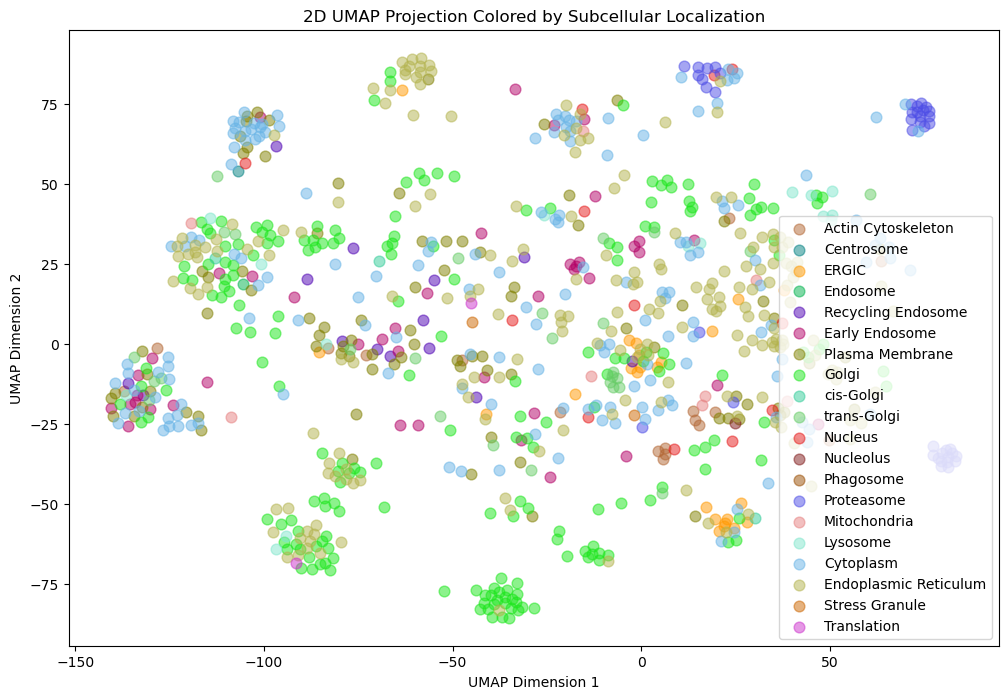

In [43]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0), 
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Stress Granule': (0.8, 0.4, 0.0, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0)
}

# Extract subcellular localization for each gene
subcellular_localization_df = pd.DataFrame(
    [(gene, locs[0]) for gene, attrs in gene_dict.items() for locs in [attrs.get('subcellular_localization', [''])] if locs],
    columns=['gene', 'subcellular_localization'])


# Convert UMAP embedding to a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

# Add a 'gene' column from your original DataFrame for alignment
embedding_df['gene'] = one_hot_encoded_df['gene'].values

# Merge the UMAP results with subcellular localization
umap_localization_df = pd.merge(embedding_df, subcellular_localization_df, on='gene')

# Now plot with color coding
plt.figure(figsize=(12, 8))
for loc, color in localization_colors.items():
    # Find the subset of the data frame that corresponds to the current localization
    subset = umap_localization_df[umap_localization_df['subcellular_localization'] == loc]
    # Plot this subset with the predefined color
    plt.scatter(subset['UMAP_1'], subset['UMAP_2'], label=loc, color=color, s=60, alpha=0.5)

plt.legend()
plt.title('2D UMAP Projection Colored by Subcellular Localization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
with open('gene_dict.pkl', 'wb') as f:
    pickle.dump(gene_dict, f)

In [ ]:
with open('process_dict.pkl', 'wb') as f:
    pickle.dump(process_dict, f)

## 2. Network Visualization

### 2.1 Group by the processes and color by the parent process

In [19]:
# Colouring the nodes according the systems
category_colors = {
    'Translocation': 'blue',
    'Protein conformation': 'red',
    'Post-translational modifications': 'green',
    'Proteostasis': 'purple',
    'Vesicle trafficking': 'yellow'
}

In [ ]:
####--- Plot the genes grouped by processes and color coded by the parent term ---####

# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.5)   # Set fixed position for nodes
# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]

nx.draw(G, pos, node_color=node_colors, edgelist=edgelist, node_size=300, edge_color='lightgrey', 
        width=[G[u][v]['weight'] for u, v in G.edges()], ax=ax)  # Set edge width to be proportional to the shared processes

# labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12) 

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 30}) 

plt.savefig('gene_network.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Group by the porcesses and color by the subcellular localization

In [30]:
localization_colors_2 = {
    'Endosome': (0.8, 0.2, 0.2, 1.0), 
    'Recycling Endosome': (0.9, 0.3, 0.3, 1.0), 
    'Early Endosome': (0.85, 0.25, 0.25, 1.0), 
    'Late Endosome': (0.75, 0.15, 0.15, 1.0), 
    'Plasma Membrane': (0.2, 0.2, 0.8, 1.0), 
    'Golgi': (0.2, 0.8, 0.2, 1.0), 
    'cis-Golgi': (0.25, 0.85, 0.25, 1.0),
    'trans-Golgi': (0.15, 0.75, 0.15, 1.0), 
    'Nucleus': (0.9, 0.9, 0.1, 1.0),
    'Phagosome': (0.8, 0.2, 0.8, 1.0), 
    'Mitochondria': (0.1, 0.9, 0.9, 1.0),
    'Lysosome': (0.5, 0.2, 0.7, 1.0),  
    'Cytoplasm': (0.6, 0.6, 0.1, 1.0),
    'Endoplasmic Reticulum': (0.2, 0.6, 0.6, 1.0)
}

localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0), 
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Stress Granule': (0.8, 0.4, 0.0, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0)
}

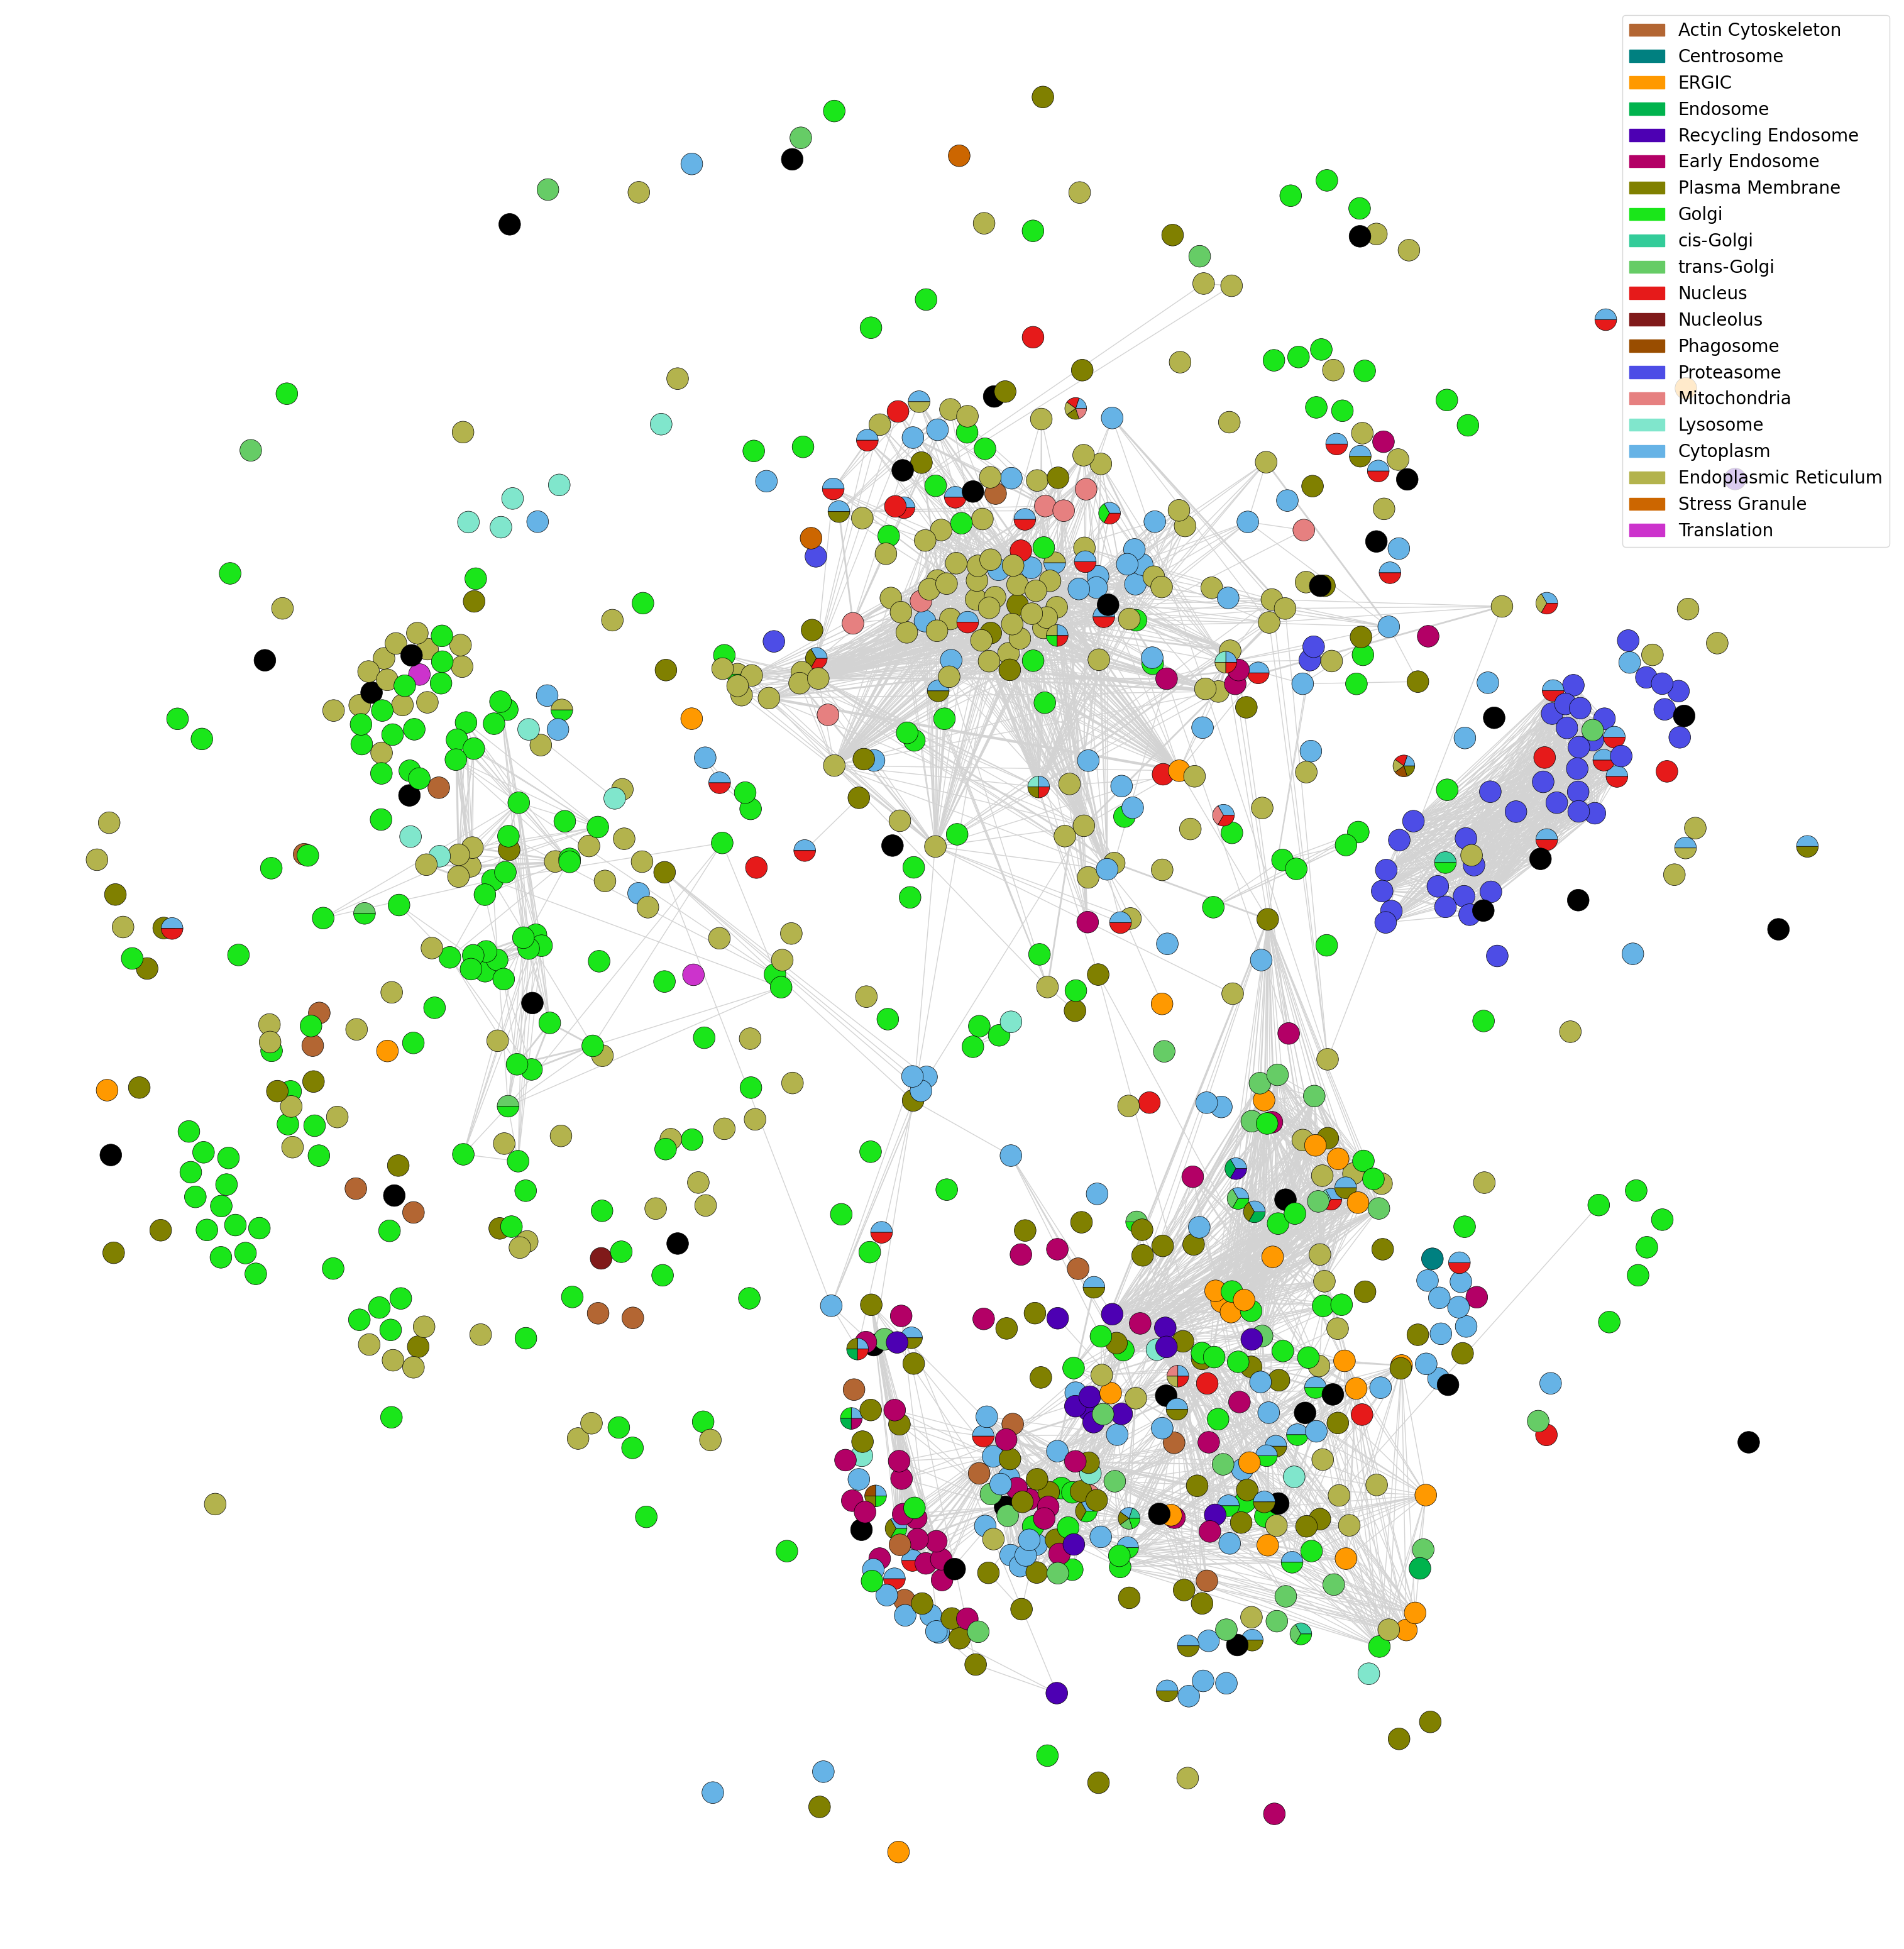

In [31]:
####--- Plot the genes grouped by processes and color coded by subcellular localization ---####

# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Create the figure first
fig, ax = plt.subplots(figsize=(40, 40))

# Layout
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.5)

# Draw edges first
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges()])

# Draw nodes as pie charts (after edges)
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    if not localizations:
        plt.pie([1], colors=['black'], radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    else:
        colors = [localization_colors[loc] for loc in localizations]
        plt.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))

# Draw labels
#label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
#nx.draw_networkx_labels(G, label_pos, font_size=12)

# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 20}, loc='upper right', bbox_to_anchor=(1, 1))

#plt.savefig('gene_network_subcellularloc.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.3 Add the complex information to the plot and color by the processes

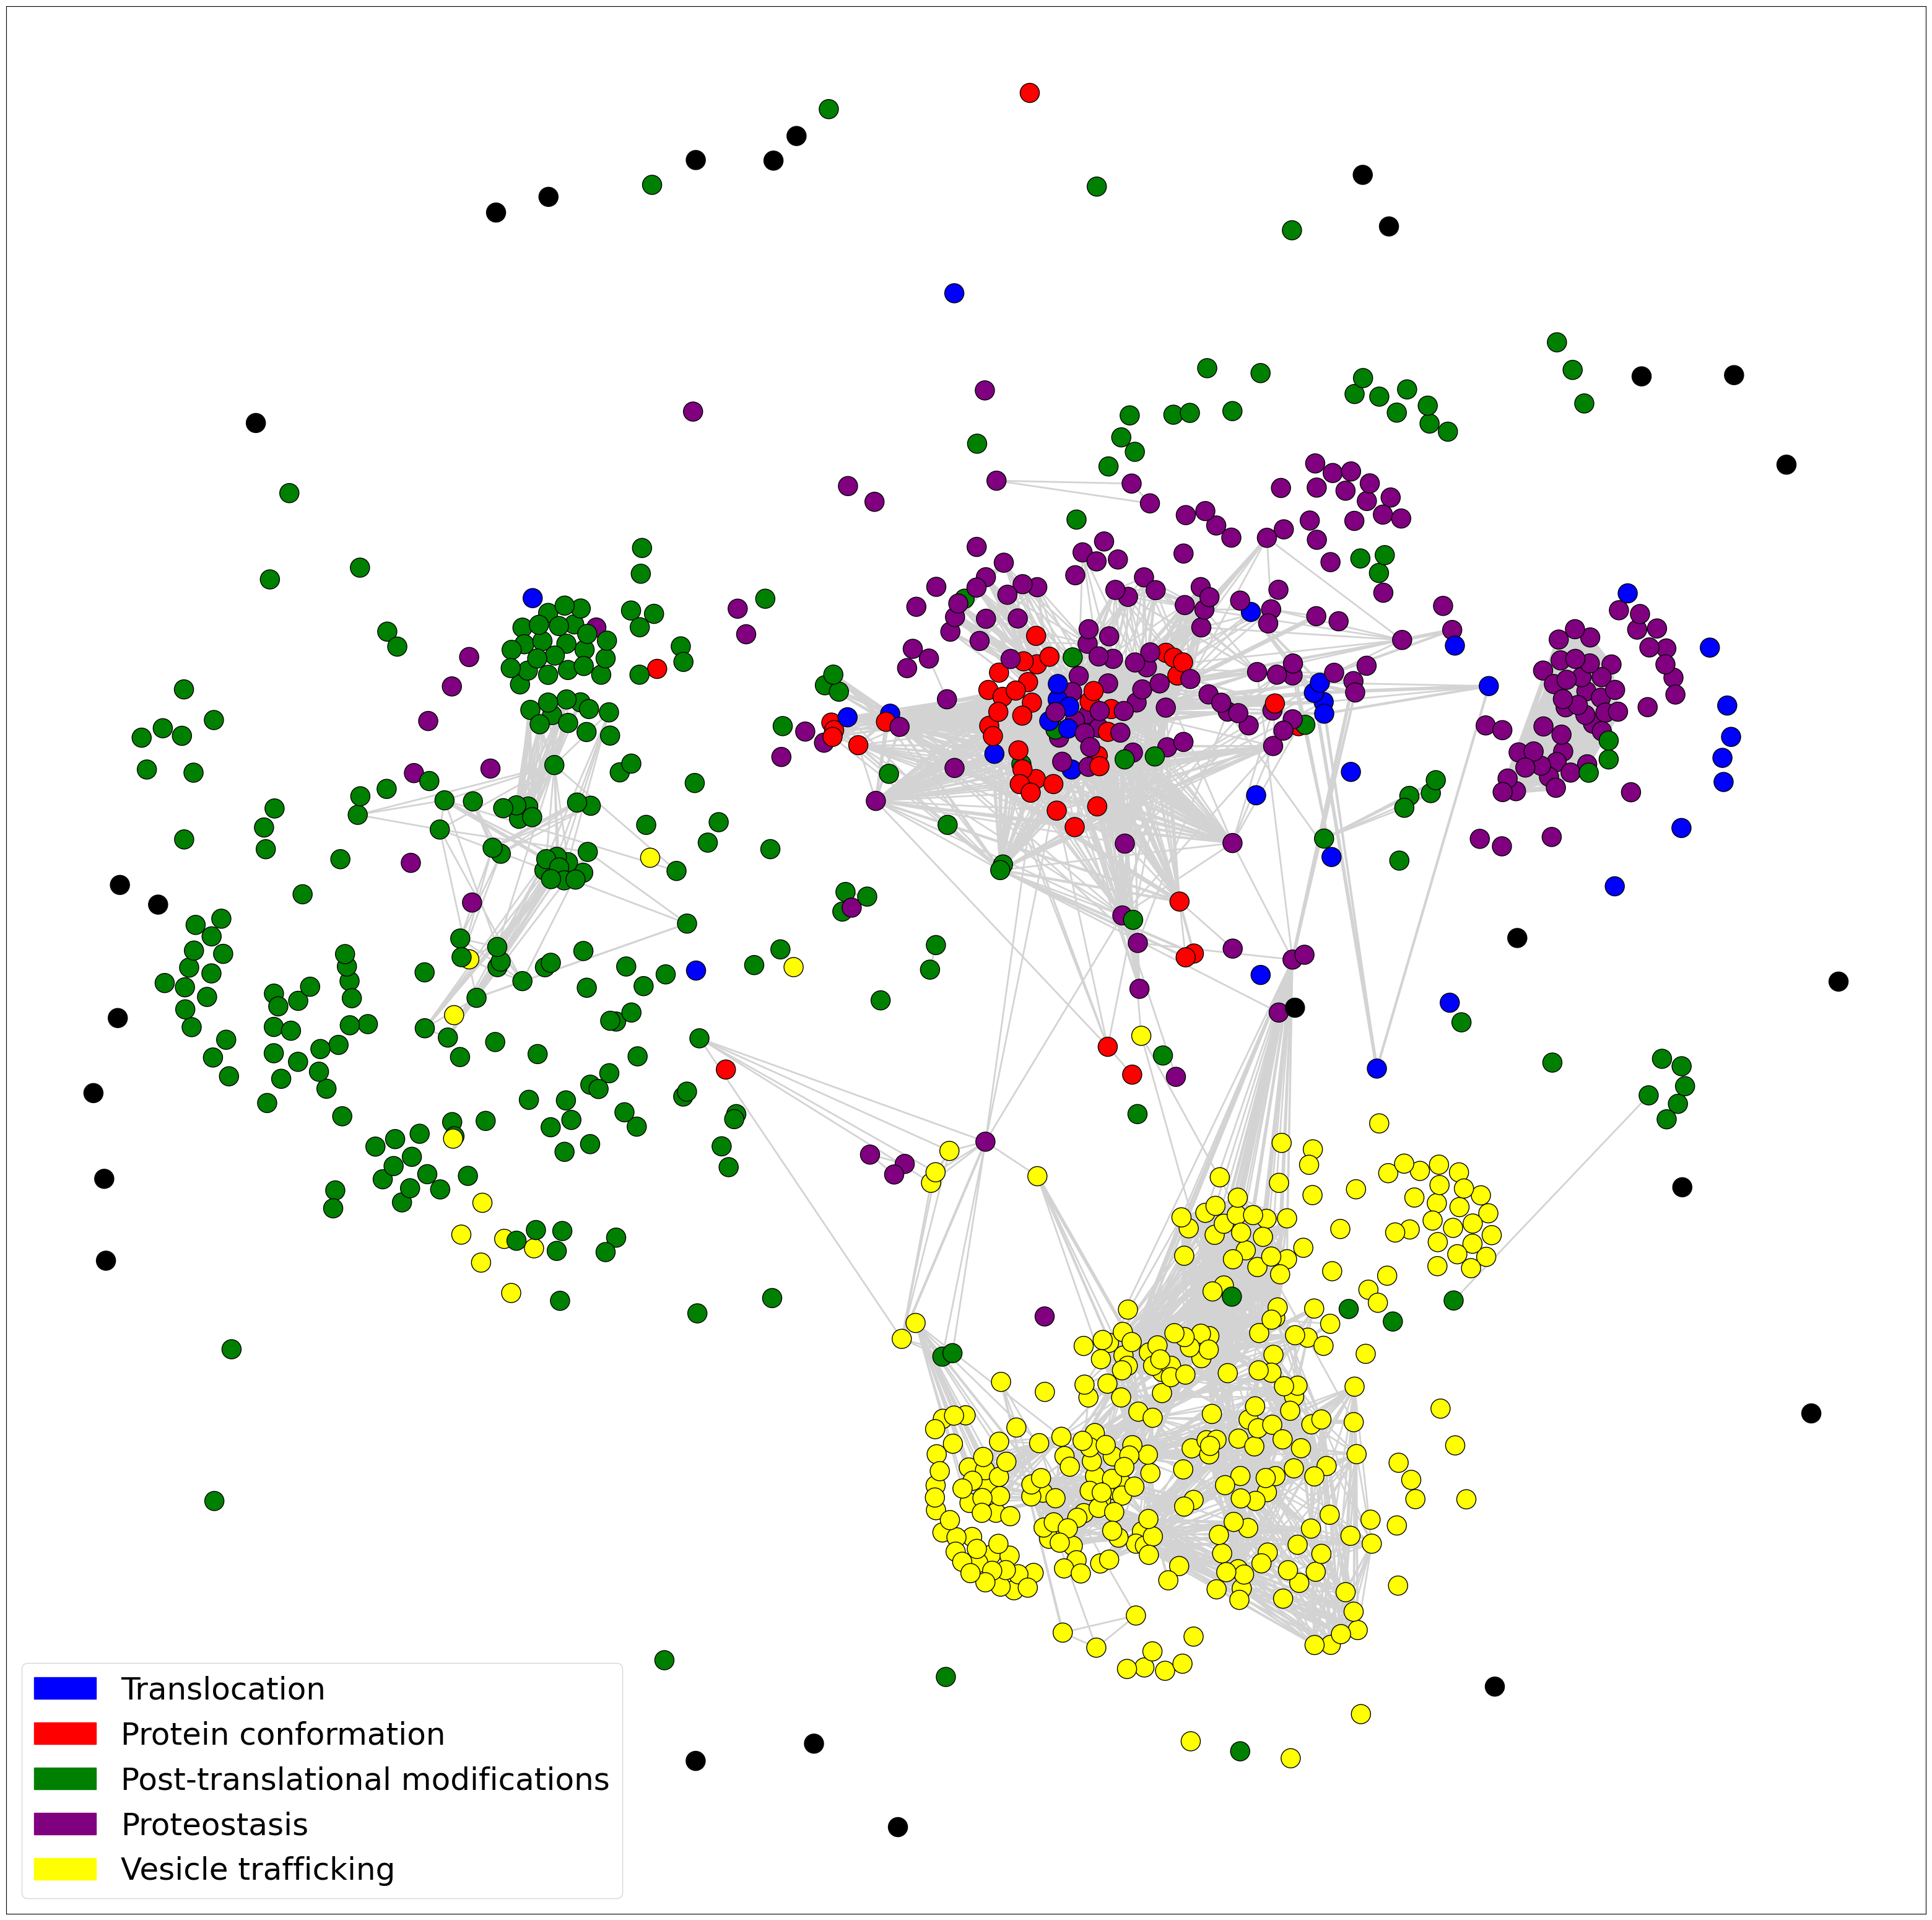

In [32]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 1

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    # Check for shared complex
    if gene_dict[gene1]['complex'] is None or gene_dict[gene2]['complex'] is None:
        shared_complex = 0
    else:
        shared_complex = len(set(gene_dict[gene1]['complex'] or []).intersection(gene_dict[gene2]['complex'] or []))
        
    edge_weight = shared_processes + shared_complex
    G.add_edge(gene1, gene2, weight=edge_weight)
        
# Color code node according to the System they belong to
base_alpha = 0.5 # Set base transparency level
node_colors = [adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), 1.0) if gene_dict[node]['complex'] != 'Not part of any complex' else adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), base_alpha) for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)   # Set fixed position for nodes

# Create dictionary to store each complex's nodes' positions
complex_positions = {}

for gene in G.nodes:
    complex_ = gene_dict[gene]['complex']
    
    # Check if the gene is part of any complex
    if complex_ == 'Not part of any complex':
        continue
    
    # If the complex field is a list, iterate over each complex
    if isinstance(complex_, list):
        for comp in complex_:
            if comp not in complex_positions:
                complex_positions[comp] = []
            complex_positions[comp].append(pos[gene])
    else:  # If the complex field is a string, add the gene to the corresponding complex
        if complex_ not in complex_positions:
            complex_positions[complex_] = []
        complex_positions[complex_].append(pos[gene])
        
# Now compute average position and max radius for each complex
complex_centers_radii = {}
for complex_, positions in complex_positions.items():
    avg_position = np.mean(positions, axis=0)
    max_radius = max(np.linalg.norm(np.array(position)-avg_position) for position in positions)
    complex_centers_radii[complex_] = (avg_position, max_radius)


# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.savefig('secrecon_network_complex.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.4 Add the complex information to the plot and color by the subcellular localization

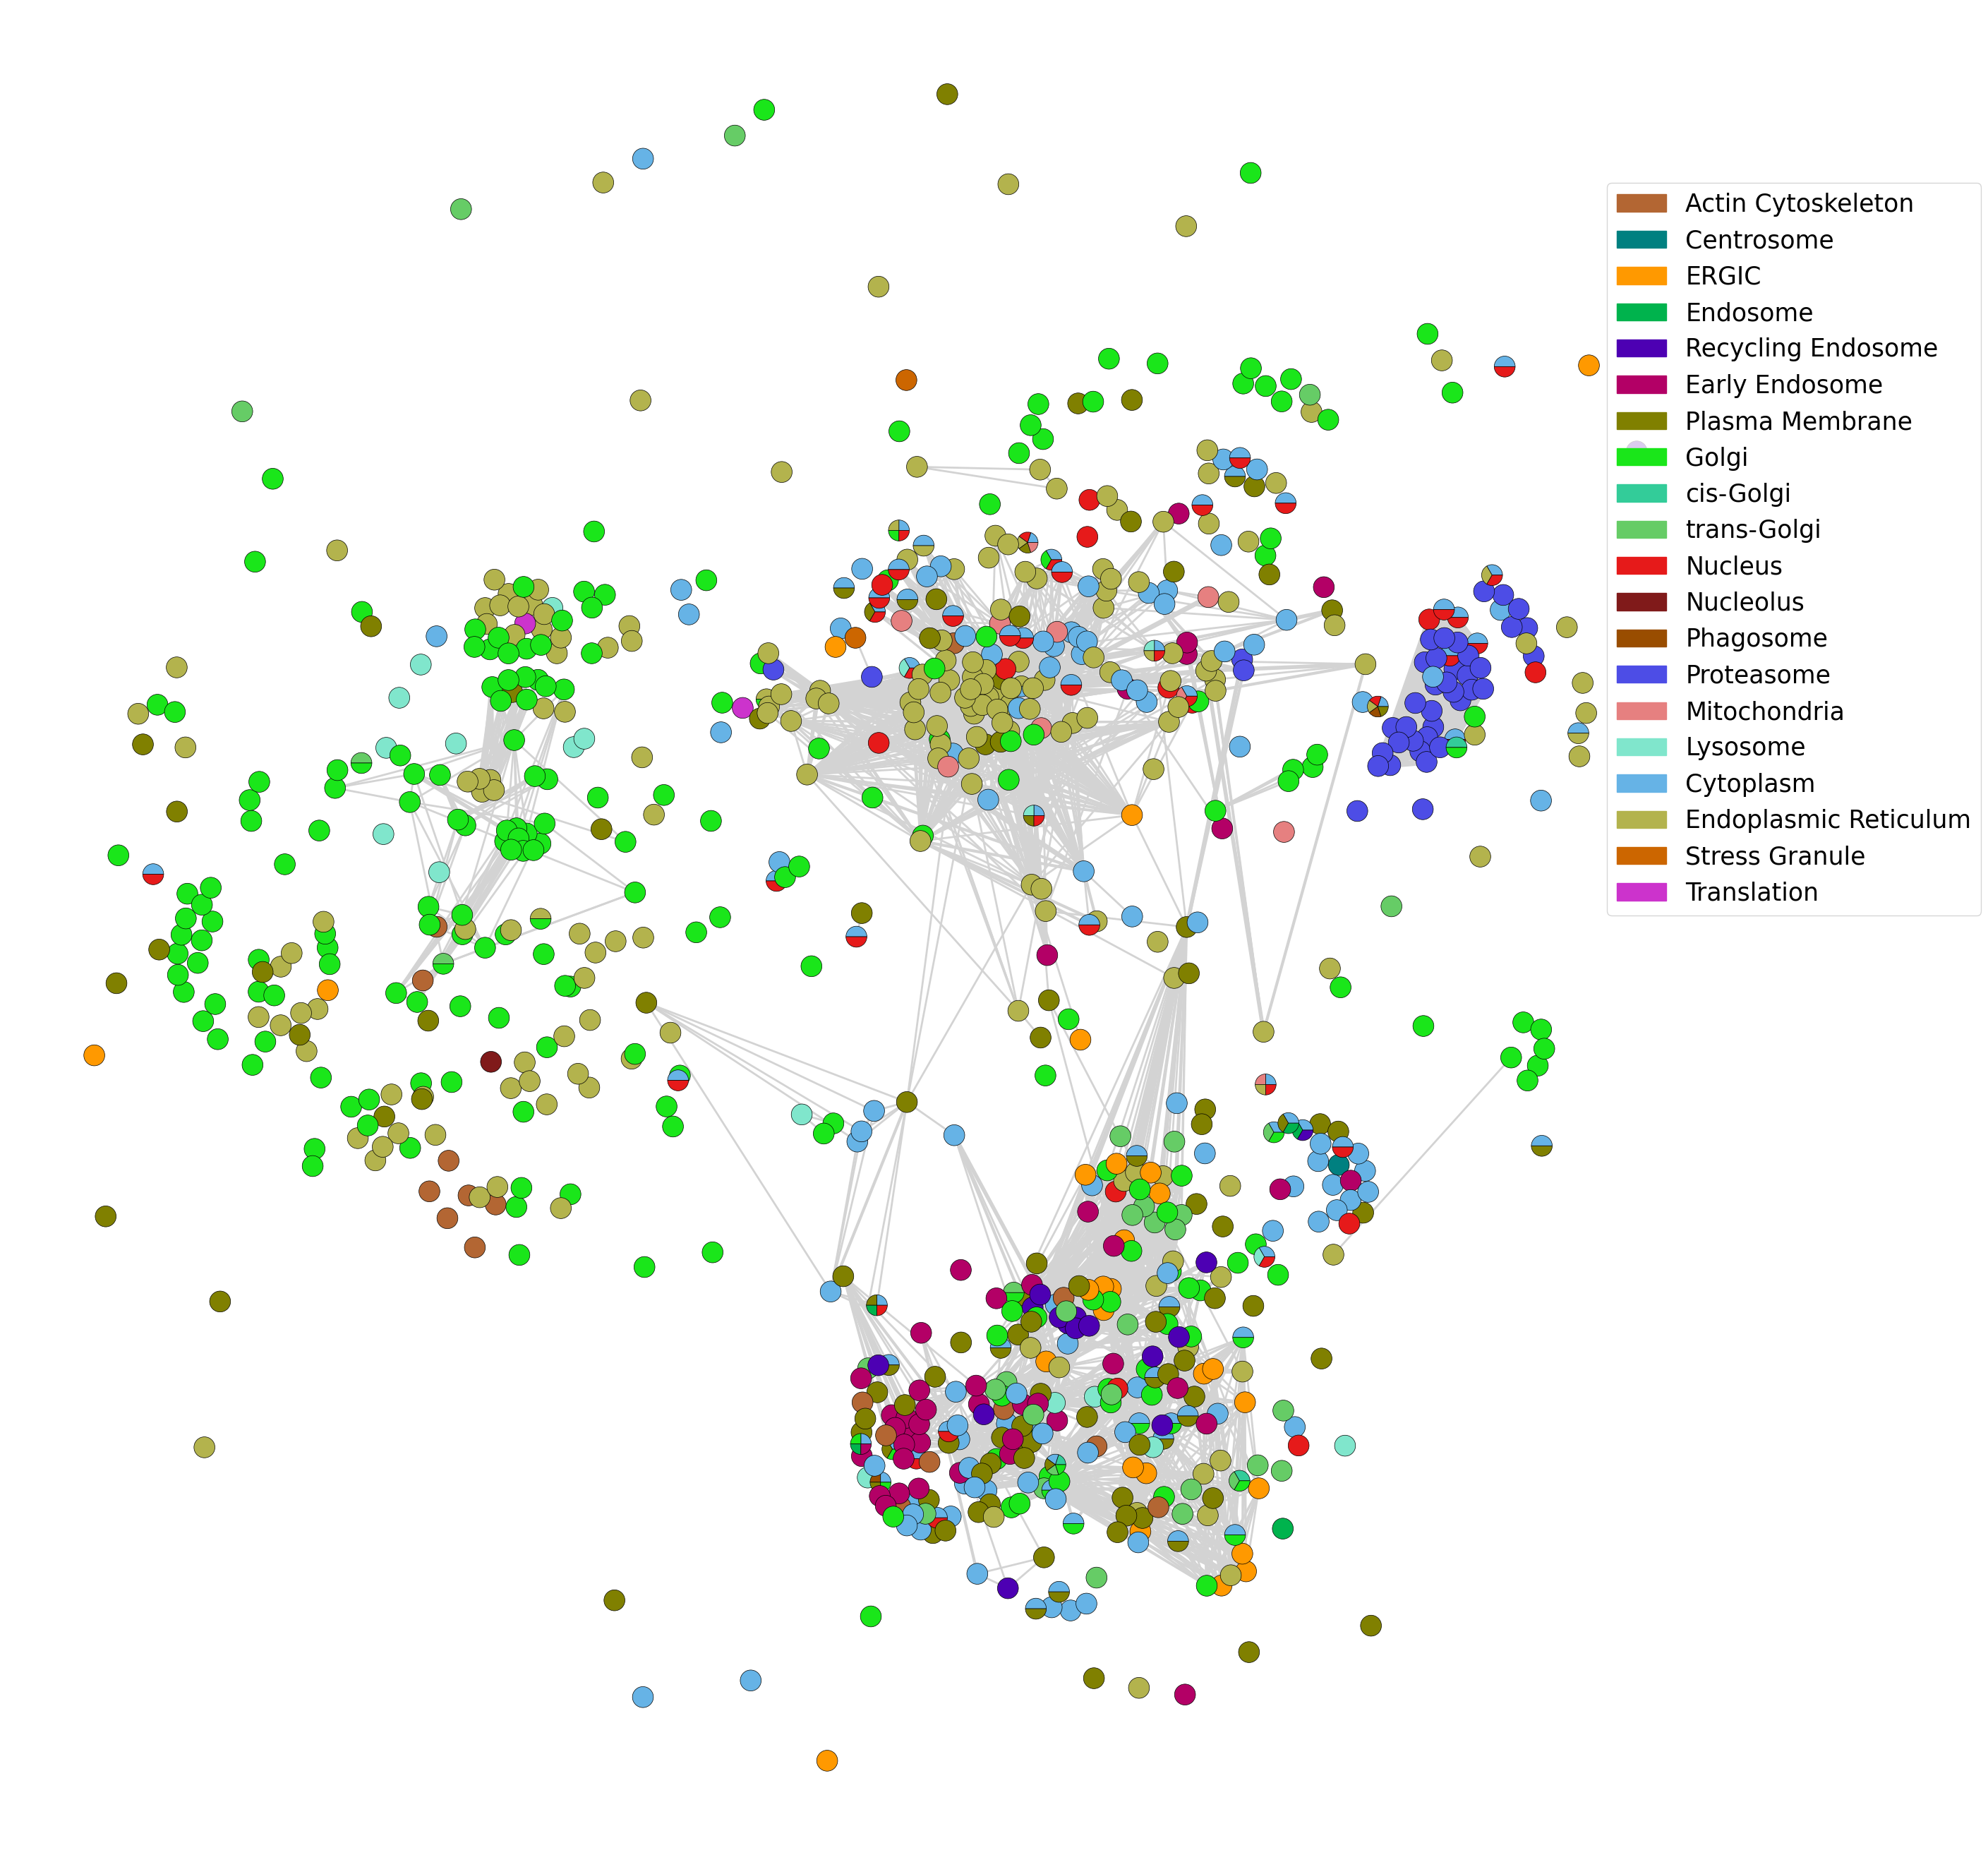

In [53]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 0.1

# Add edges to the nodes
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    # Check for shared complex
    if gene_dict[gene1]['complex'] is None or gene_dict[gene2]['complex'] is None:
        shared_complex = 0
    else:
        shared_complex = len(set(gene_dict[gene1]['complex'] or []).intersection(gene_dict[gene2]['complex'] or []))
        
    edge_weight = shared_processes + shared_complex
    G.add_edge(gene1, gene2, weight=edge_weight)
        
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Draw the graph layout
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])


def adjust_alpha(color, alpha):
    return (color[0], color[1], color[2], alpha)

# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Check if the node is part of any complex
    is_in_complex = gene_dict[node]['complex'] != 'Not part of any complex'
    
    # Set alpha value based on whether the node is in a complex
    alpha_value = 1.0 if is_in_complex else 0.5
    
    # Adjust the alpha value of each color
    colors = [adjust_alpha(localization_colors[loc], alpha_value) for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    ax.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.9, 0.5))
plt.subplots_adjust(right=0.75)

plt.savefig('gene_network_with_pie_charts.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()